# Importing Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, DenseNet169
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Loading Data & Assigning Labels

In [3]:
def load_data(base_dir):
    data = []
    labels = []
    
    categories = [
        'XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 
        'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST'
    ]
    
    for category in categories:
        for label in ['negative', 'positive']:
            path = os.path.join(base_dir, category)
            file_paths = glob(os.path.join(path, '**', f'*_{label}'), recursive=True)
            for file_path in file_paths:
                for img in glob(os.path.join(file_path, '*.png')):
                    data.append(img)
                    if label == 'negative':
                        labels.append('normal')
                    else:
                        labels.append('abnormal')
                    
    return pd.DataFrame({'image_path': data, 'label': labels})

# Define directories for training and validation
train_dir = 'MURA-v1.1/train'
valid_dir = 'MURA-v1.1/valid'

# Load data into dataframes for both training and validation
train_df = load_data(train_dir)
valid_df = load_data(valid_dir)

# Display the first few rows of each dataframe to verify the data loading
print(train_df.head())
print(valid_df.head())



                                          image_path   label
0  MURA-v1.1/train\XR_ELBOW\patient00011\study1_n...  normal
1  MURA-v1.1/train\XR_ELBOW\patient00011\study1_n...  normal
2  MURA-v1.1/train\XR_ELBOW\patient00011\study1_n...  normal
3  MURA-v1.1/train\XR_ELBOW\patient00026\study1_n...  normal
4  MURA-v1.1/train\XR_ELBOW\patient00026\study1_n...  normal
                                          image_path   label
0  MURA-v1.1/valid\XR_ELBOW\patient11204\study1_n...  normal
1  MURA-v1.1/valid\XR_ELBOW\patient11204\study1_n...  normal
2  MURA-v1.1/valid\XR_ELBOW\patient11205\study1_n...  normal
3  MURA-v1.1/valid\XR_ELBOW\patient11205\study1_n...  normal
4  MURA-v1.1/valid\XR_ELBOW\patient11205\study1_n...  normal


In [4]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Class Distribution

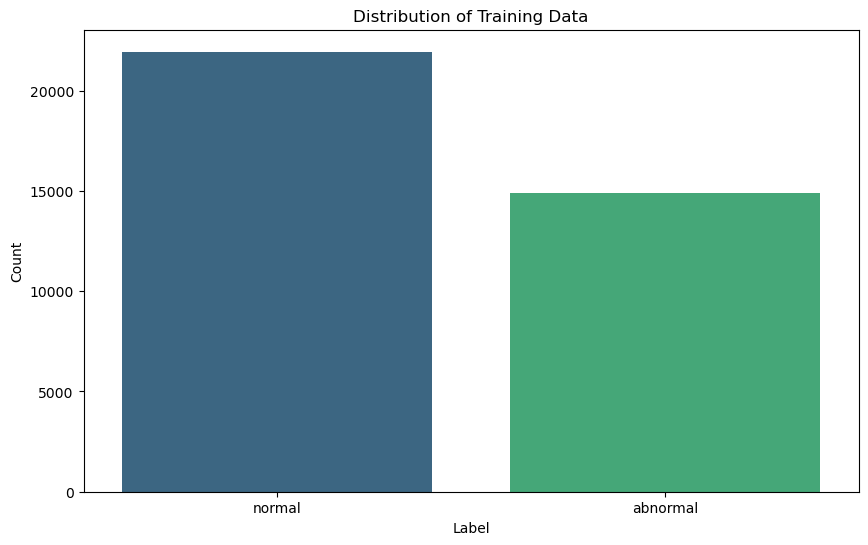

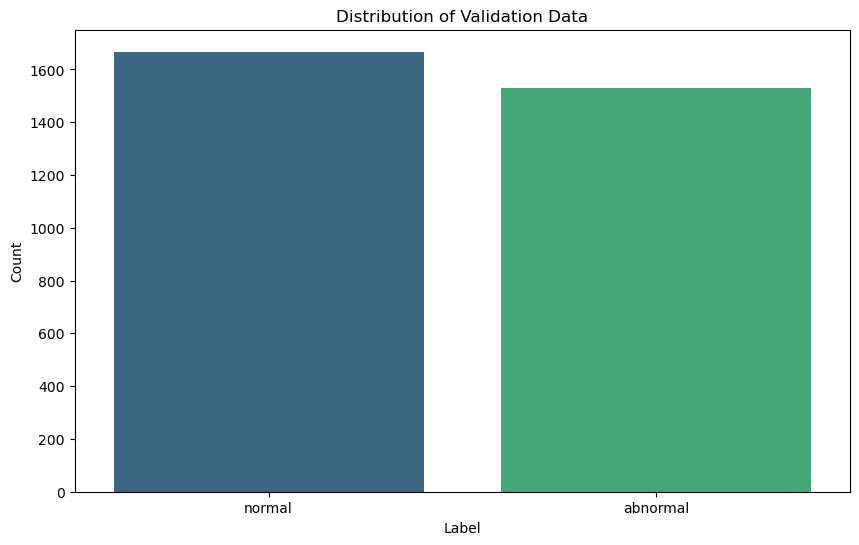

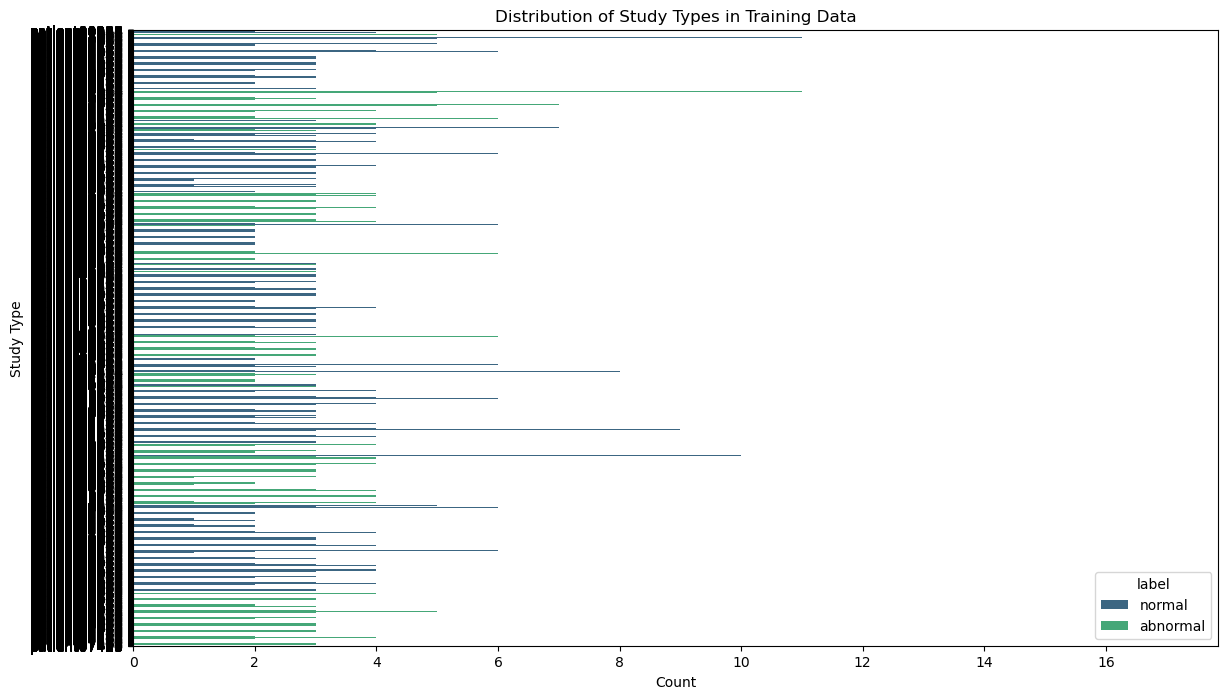

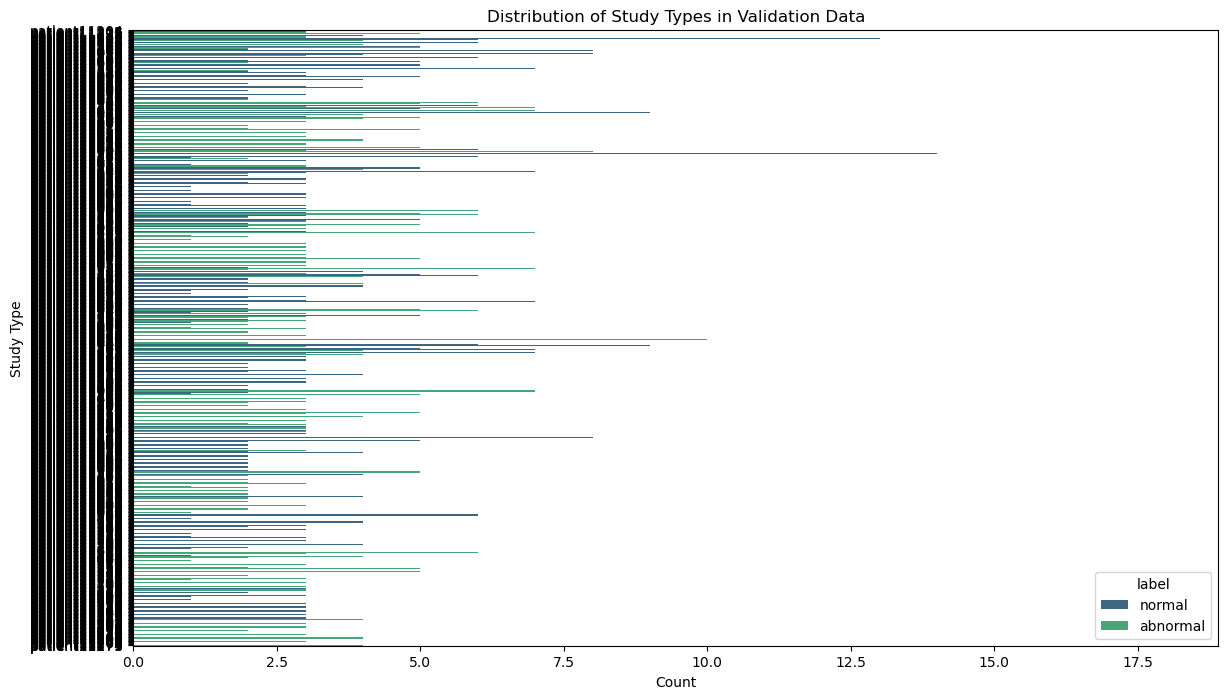

In [5]:

# Function to plot the distribution of labels in the dataset
def plot_label_distribution(df, title):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='label', data=df, palette='viridis')
    plt.title(f'Distribution of {title}')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

# Function to plot the distribution of study types in the dataset
def plot_study_type_distribution(df, title):
    plt.figure(figsize=(14, 8))
    sns.countplot(y='study_type', hue='label', data=df, palette='viridis')
    plt.title(f'Distribution of Study Types in {title}')
    plt.xlabel('Count')
    plt.ylabel('Study Type')
    plt.show()

# Adding a new column 'study_type' to the dataframes based on the image paths
train_df['study_type'] = train_df['image_path'].apply(lambda x: x.split(os.sep)[-3])
valid_df['study_type'] = valid_df['image_path'].apply(lambda x: x.split(os.sep)[-3])

# Plot the distribution of labels in the training and validation datasets
plot_label_distribution(train_df, 'Training Data')
plot_label_distribution(valid_df, 'Validation Data')

# Plot the distribution of study types in the training and validation datasets
plot_study_type_distribution(train_df, 'Training Data')
plot_study_type_distribution(valid_df, 'Validation Data')


# Category or Study-type distribution

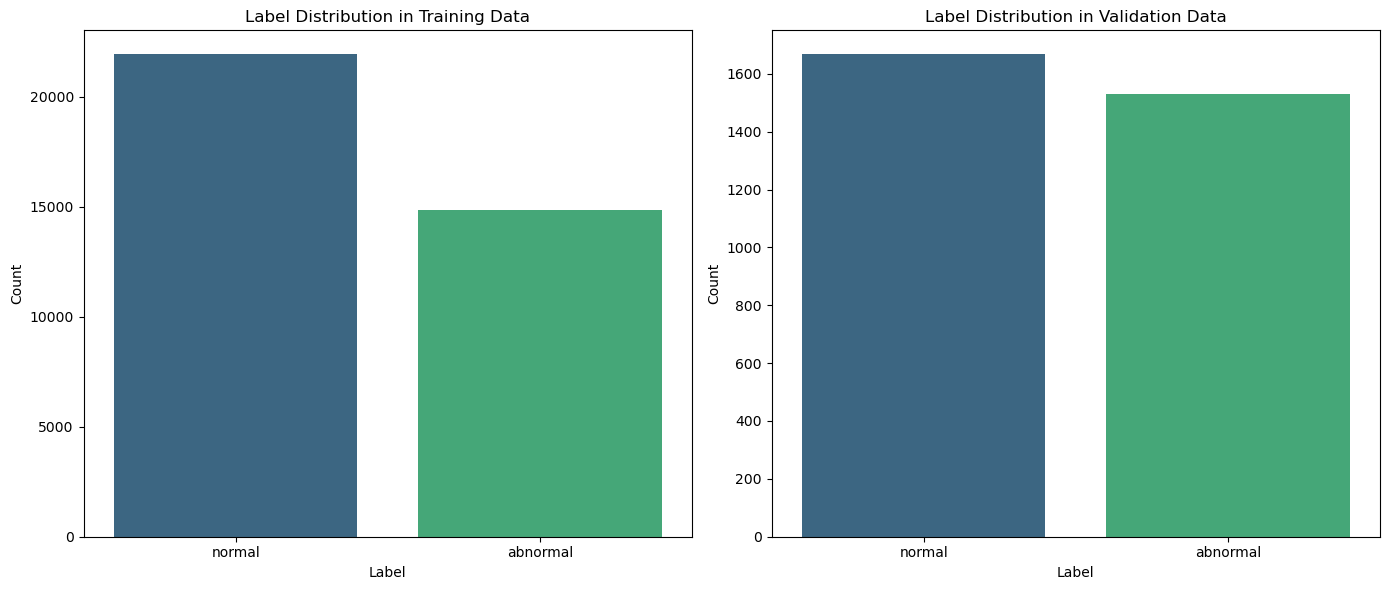

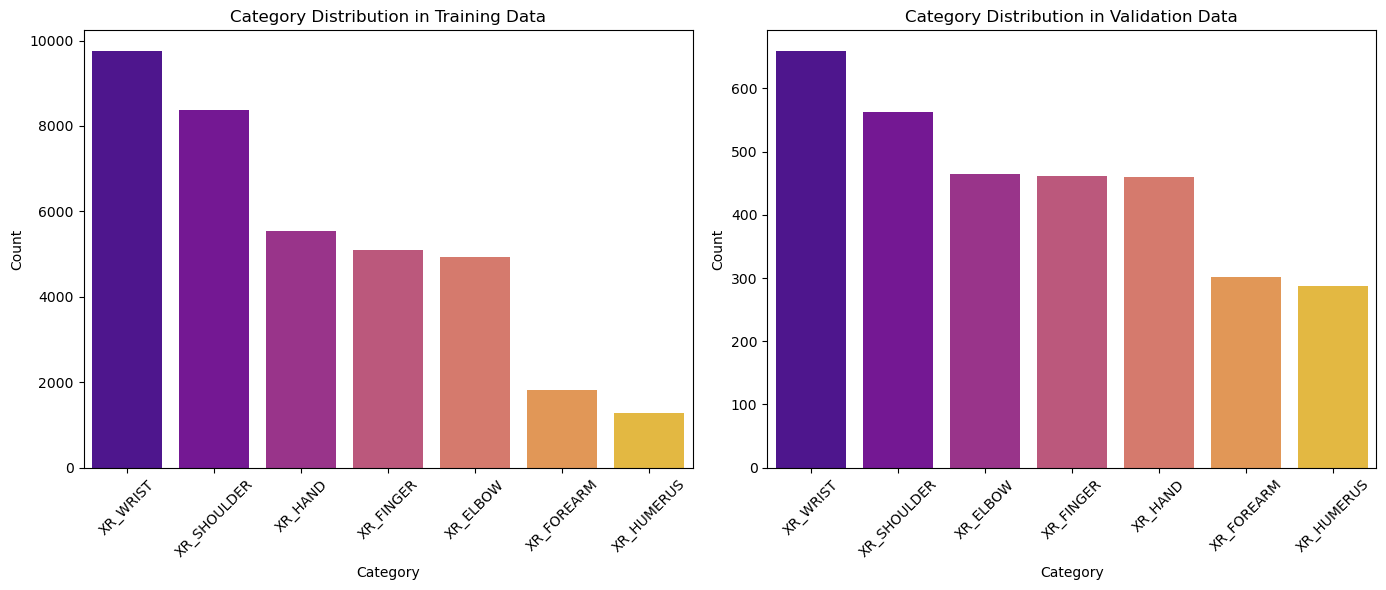

In [6]:
# Counting labels in the training dataset
train_label_distribution = train_df['label'].value_counts()
valid_label_distribution = valid_df['label'].value_counts()

# Plotting the distribution of labels
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=train_label_distribution.index, y=train_label_distribution.values, palette='viridis')
plt.title('Label Distribution in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.barplot(x=valid_label_distribution.index, y=valid_label_distribution.values, palette='viridis')
plt.title('Label Distribution in Validation Data')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Counting the categories in the training dataset
train_category_distribution = train_df['image_path'].apply(lambda x: x.split(os.sep)[1]).value_counts()
valid_category_distribution = valid_df['image_path'].apply(lambda x: x.split(os.sep)[1]).value_counts()

# Plotting the distribution of categories
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=train_category_distribution.index, y=train_category_distribution.values, palette='plasma')
plt.title('Category Distribution in Training Data')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=valid_category_distribution.index, y=valid_category_distribution.values, palette='plasma')
plt.title('Category Distribution in Validation Data')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


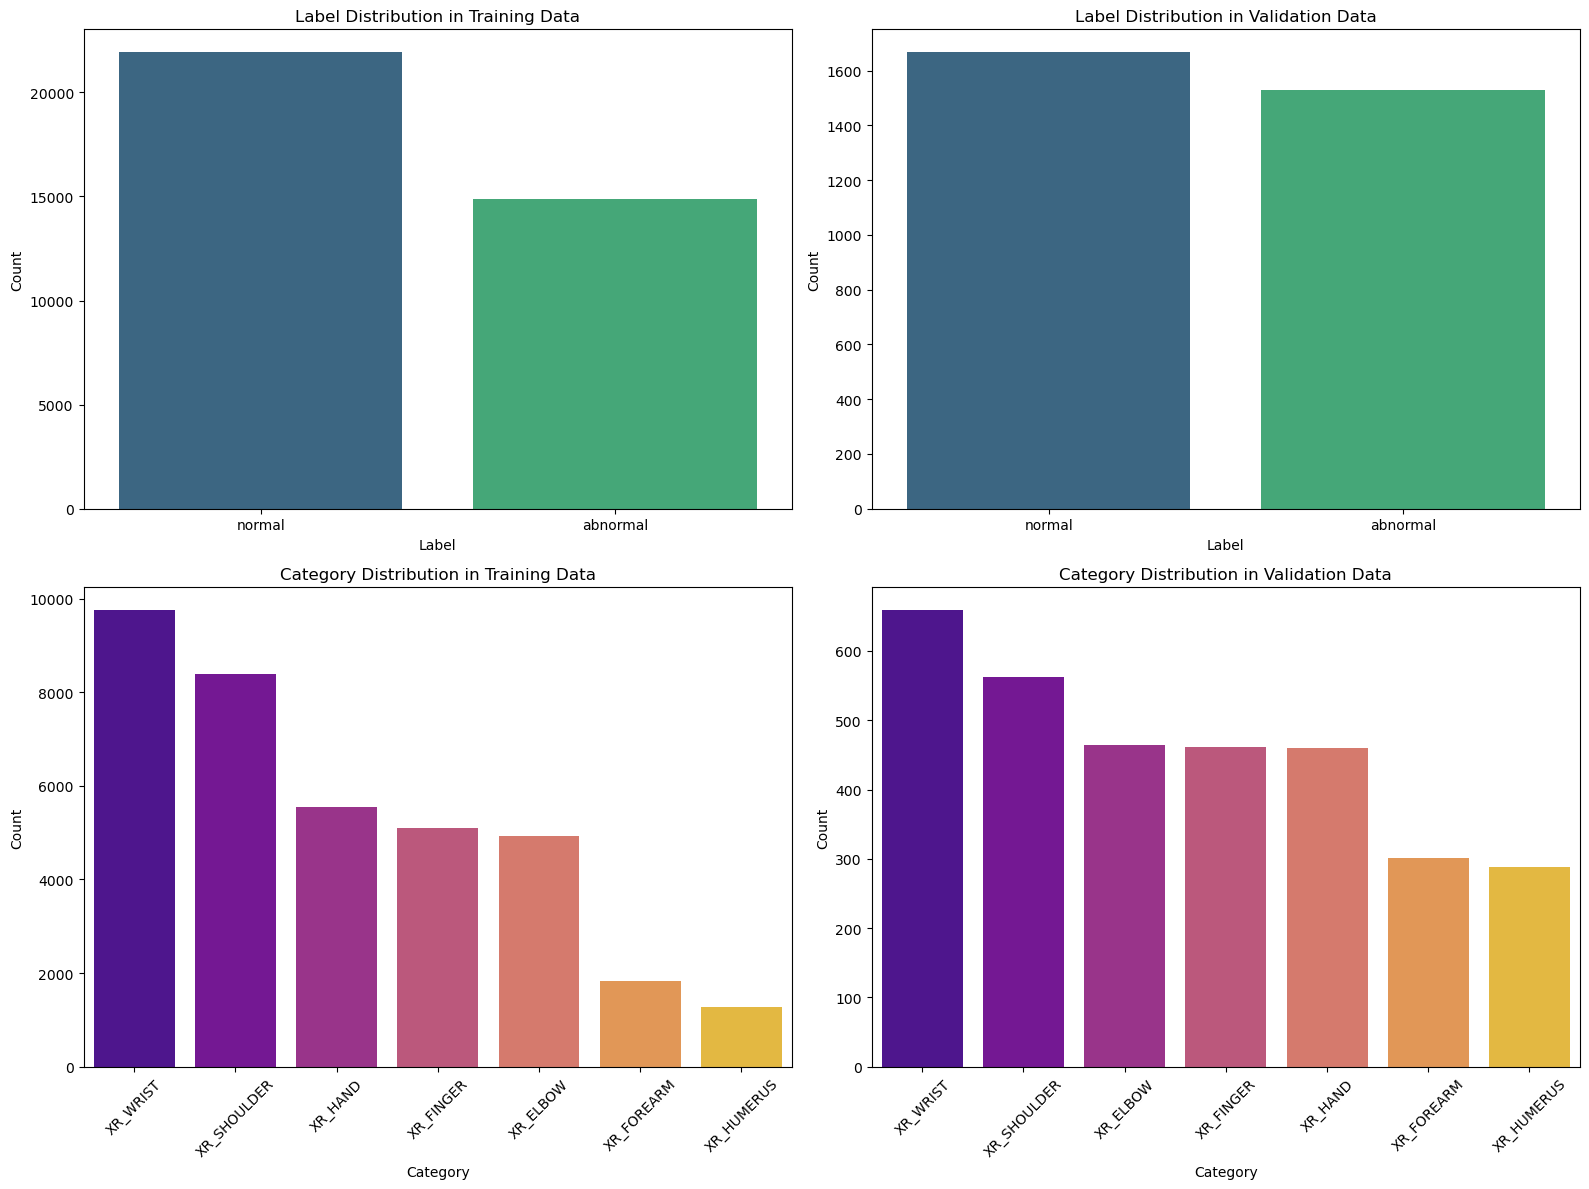

In [7]:

train_df['category'] = train_df['image_path'].apply(lambda x: x.split(os.sep)[1])
valid_df['category'] = valid_df['image_path'].apply(lambda x: x.split(os.sep)[1])

# Counting the occurrences of each label and category in the training and validation datasets
train_label_distribution = train_df['label'].value_counts()
valid_label_distribution = valid_df['label'].value_counts()

train_category_distribution = train_df['category'].value_counts()
valid_category_distribution = valid_df['category'].value_counts()

# Plotting the label and category distributions
plt.figure(figsize=(16, 12))

# Label distribution in training data
plt.subplot(2, 2, 1)
sns.barplot(x=train_label_distribution.index, y=train_label_distribution.values, palette='viridis')
plt.title('Label Distribution in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')

# Label distribution in validation data
plt.subplot(2, 2, 2)
sns.barplot(x=valid_label_distribution.index, y=valid_label_distribution.values, palette='viridis')
plt.title('Label Distribution in Validation Data')
plt.xlabel('Label')
plt.ylabel('Count')

# Category distribution in training data
plt.subplot(2, 2, 3)
sns.barplot(x=train_category_distribution.index, y=train_category_distribution.values, palette='plasma')
plt.title('Category Distribution in Training Data')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Category distribution in validation data
plt.subplot(2, 2, 4)
sns.barplot(x=valid_category_distribution.index, y=valid_category_distribution.values, palette='plasma')
plt.title('Category Distribution in Validation Data')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


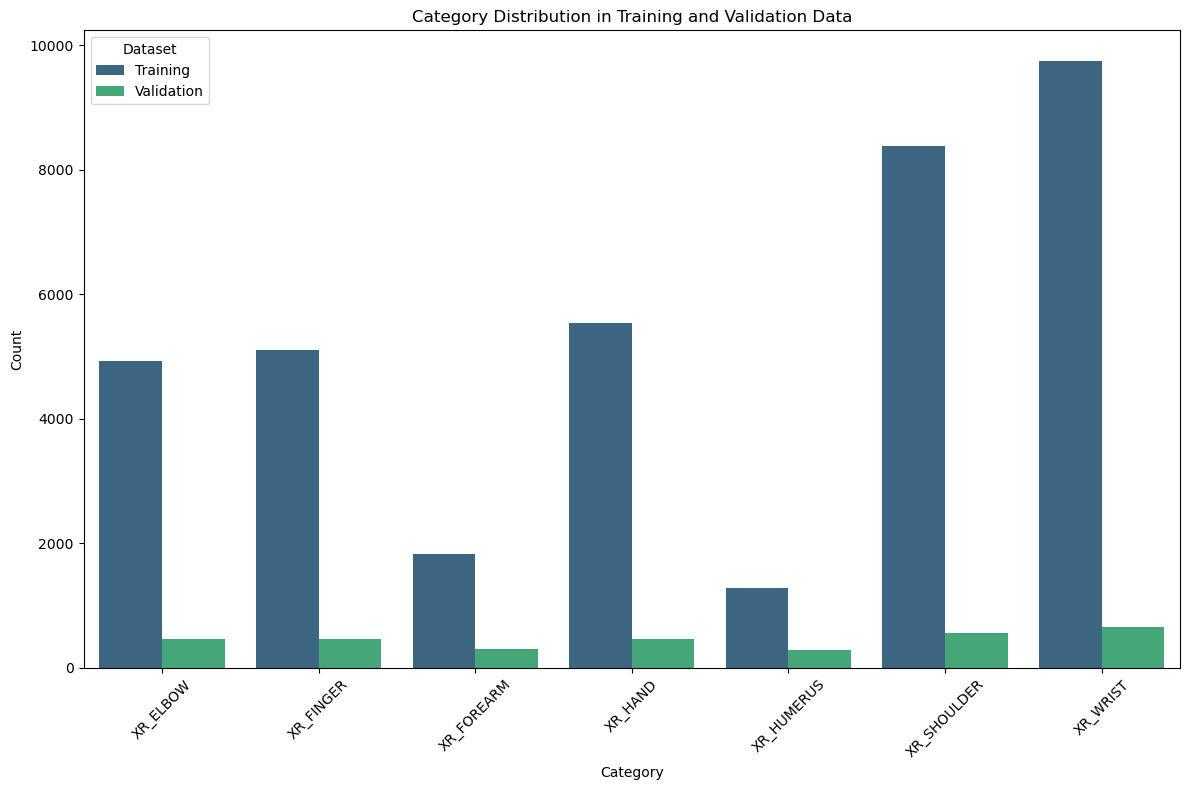

In [8]:

train_df['category'] = train_df['image_path'].apply(lambda x: x.split(os.sep)[1])
valid_df['category'] = valid_df['image_path'].apply(lambda x: x.split(os.sep)[1])


train_category_distribution = train_df['category'].value_counts().sort_index()
valid_category_distribution = valid_df['category'].value_counts().sort_index()


combined_df = pd.DataFrame({
    'Category': train_category_distribution.index,
    'Training': train_category_distribution.values,
    'Validation': valid_category_distribution.values
})


combined_df_melted = combined_df.melt(id_vars='Category', var_name='Dataset', value_name='Count')


plt.figure(figsize=(12, 8))
sns.barplot(data=combined_df_melted, x='Category', y='Count', hue='Dataset', palette='viridis')

plt.title('Category Distribution in Training and Validation Data')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Dataset')

plt.tight_layout()
plt.show()


# Image distributions
# Dimensions
# Aspect Ratios
# Mean Intensities

Training Data Image Statistics Summary:
              Width        Height  Aspect Ratio  Mean Intensity  Std Intensity
count  36808.000000  36808.000000  36808.000000    36808.000000   36808.000000
mean     399.320582    491.025837      0.836399       52.471893      31.346894
std       91.215156     46.653047      0.283742       29.635543      13.093075
min       89.000000    132.000000      0.173828        0.002530       0.318558
25%      363.000000    512.000000      0.708984       36.223875      22.329440
50%      406.000000    512.000000      0.792969       46.794151      28.684430
75%      482.250000    512.000000      0.941895       57.617995      37.066591
max      512.000000    512.000000      3.878788      179.963207     109.455655
Validation Data Image Statistics Summary:
             Width       Height  Aspect Ratio  Mean Intensity  Std Intensity
count  3197.000000  3197.000000   3197.000000     3197.000000    3197.000000
mean    400.943697   488.877072      0.851538       5

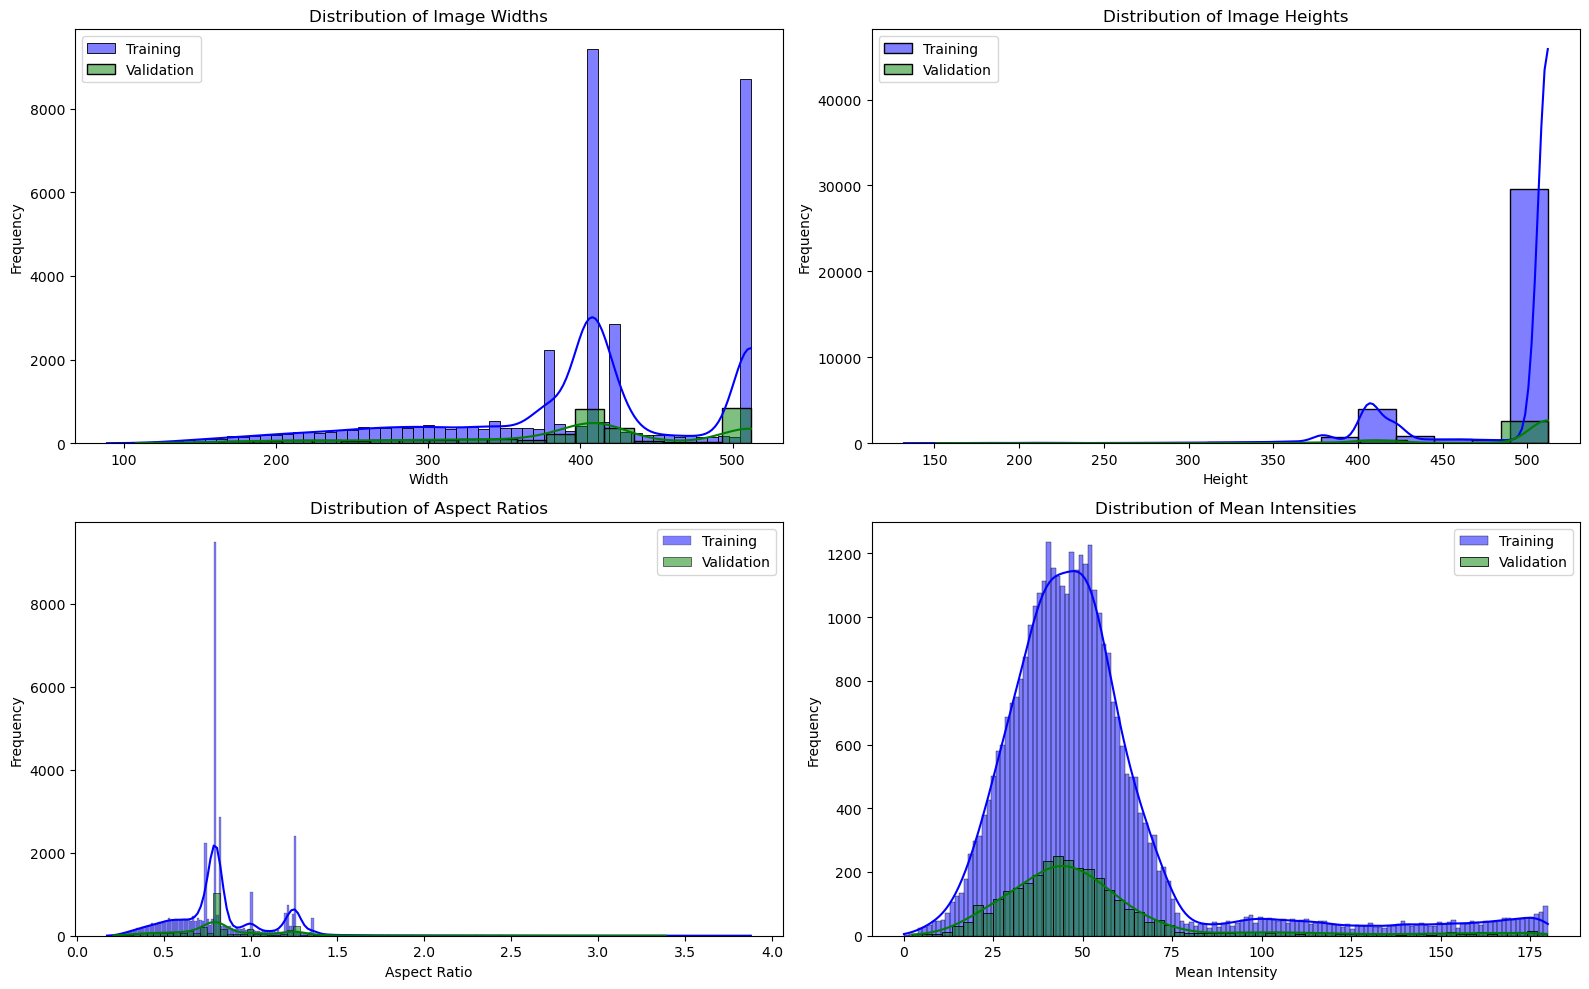

In [11]:

def analyze_images(df):
    # Initializing lists to store image statistics
    widths, heights, aspect_ratios, means, stds = [], [], [], [], []

    for img_path in df['image_path']:
        # Reading the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        height, width = img.shape

        # Calculatings statistics
        widths.append(width)
        heights.append(height)
        aspect_ratios.append(width / height)
        means.append(np.mean(img))
        stds.append(np.std(img))

    # DataFrame for the statistics
    stats_df = pd.DataFrame({
        'Width': widths,
        'Height': heights,
        'Aspect Ratio': aspect_ratios,
        'Mean Intensity': means,
        'Std Intensity': stds
    })
    
    return stats_df

# Analyzing training images
train_stats_df = analyze_images(train_df)
print("Training Data Image Statistics Summary:")
print(train_stats_df.describe())

# Analyzing validation images
valid_stats_df = analyze_images(valid_df)
print("Validation Data Image Statistics Summary:")
print(valid_stats_df.describe())

# Plotting histograms of key statistics
plt.figure(figsize=(16, 10))

# Histogram of Image Widths
plt.subplot(2, 2, 1)
sns.histplot(train_stats_df['Width'], kde=True, color='blue', label='Training')
sns.histplot(valid_stats_df['Width'], kde=True, color='green', label='Validation')
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.legend()

# Histogram of Image Heights
plt.subplot(2, 2, 2)
sns.histplot(train_stats_df['Height'], kde=True, color='blue', label='Training')
sns.histplot(valid_stats_df['Height'], kde=True, color='green', label='Validation')
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.legend()

# Histogram of Aspect Ratios
plt.subplot(2, 2, 3)
sns.histplot(train_stats_df['Aspect Ratio'], kde=True, color='blue', label='Training')
sns.histplot(valid_stats_df['Aspect Ratio'], kde=True, color='green', label='Validation')
plt.title('Distribution of Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.legend()

# Histogram of Mean Intensities
plt.subplot(2, 2, 4)
sns.histplot(train_stats_df['Mean Intensity'], kde=True, color='blue', label='Training')
sns.histplot(valid_stats_df['Mean Intensity'], kde=True, color='green', label='Validation')
plt.title('Distribution of Mean Intensities')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


# PCA & t-SNE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

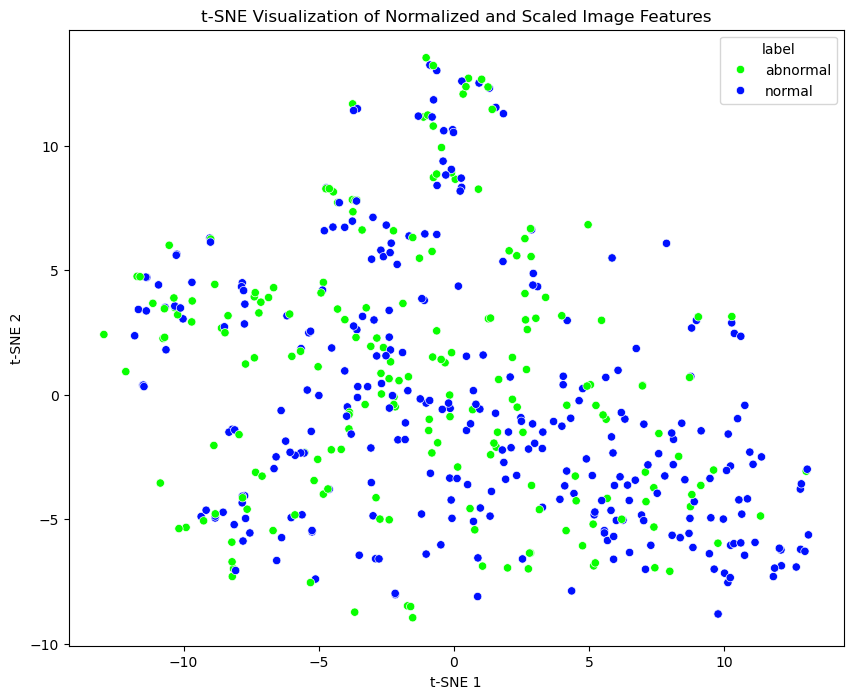

In [18]:

# Function to normalize and scale features
def normalize_and_scale(features, method='standard'):
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("method must be 'standard' or 'minmax'")
    
    scaled_features = scaler.fit_transform(features)
    return scaled_features

# Extract features from a subset of the training dataset
features, labels = extract_features(train_df.sample(500), model)

# Normalize and scale the features using StandardScaler
scaled_features = normalize_and_scale(features, method='standard')

# Perform PCA to reduce dimensionality to 50 components
pca = PCA(n_components=50)
pca_result = pca.fit_transform(scaled_features)

# Perform t-SNE on the PCA result to further reduce dimensionality to 2 components for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(pca_result)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame({'t-SNE 1': tsne_result[:, 0], 't-SNE 2': tsne_result[:, 1], 'label': labels})

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='label', data=tsne_df, palette=sns.color_palette('hsv', len(np.unique(labels))))
plt.title('t-SNE Visualization of Normalized and Scaled Image Features')
plt.show()


# Minimal Preprocessing & Augmentation results

In [3]:
# ImageDataGenerator setup for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Flow from DataFrame for training
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Binary classification based on the string labels
)

# Flow from DataFrame for validation
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 36808 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


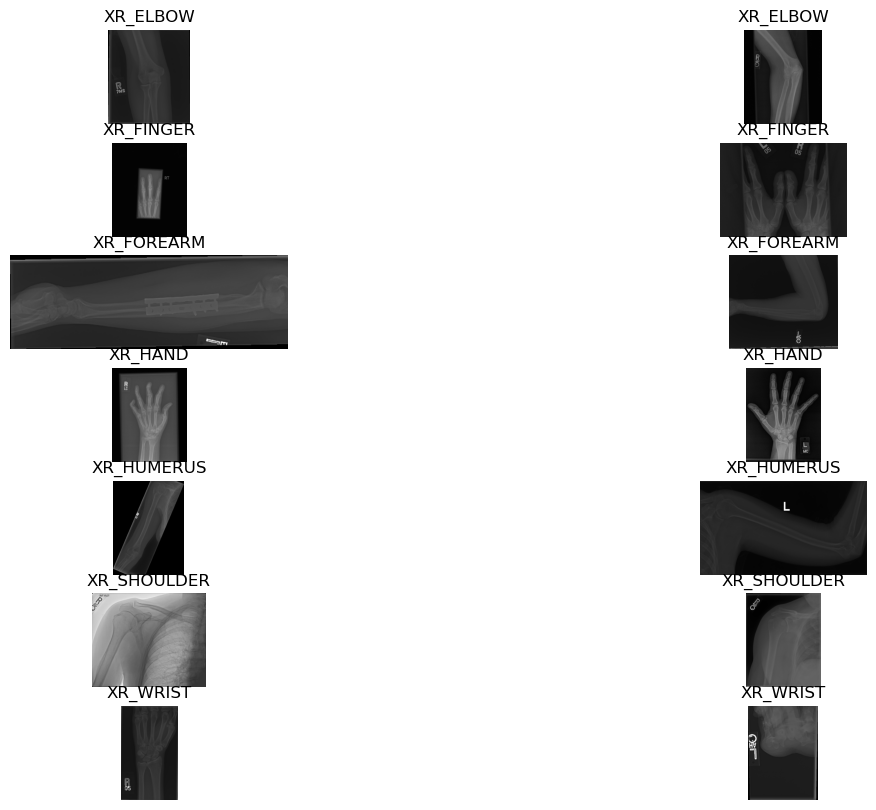

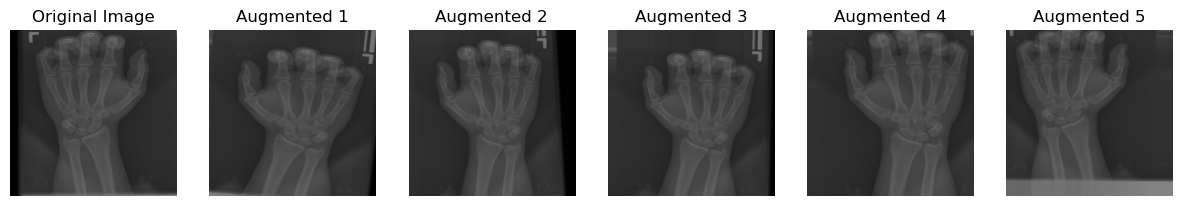

Image Size Statistics:
             Height         Width  Channels
count  36808.000000  36808.000000   36808.0
mean     491.025837    399.320582       3.0
std       46.653047     91.215156       0.0
min      132.000000     89.000000       3.0
25%      512.000000    363.000000       3.0
50%      512.000000    406.000000       3.0
75%      512.000000    482.250000       3.0
max      512.000000    512.000000       3.0


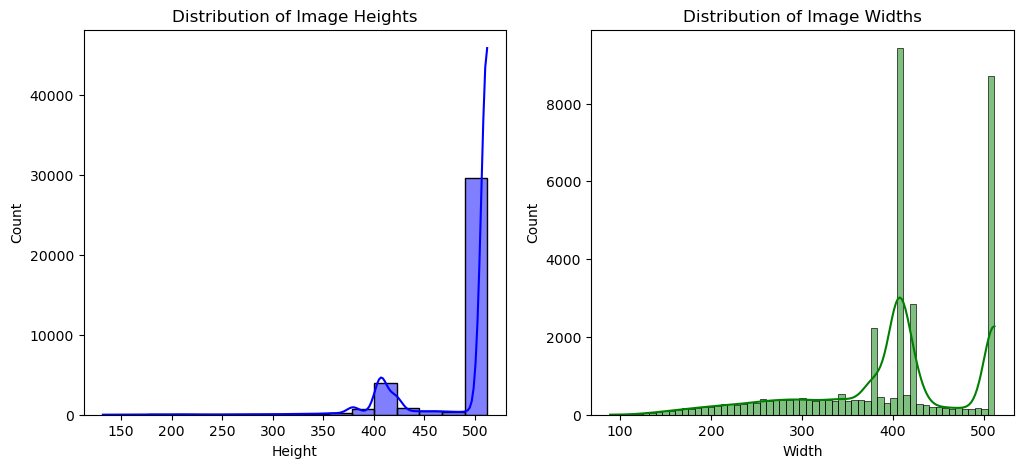

In [12]:
# displaying a random image from each category
def display_random_images(dataframe, categories, num_images=1):
    plt.figure(figsize=(15, 10))
    for i, category in enumerate(categories):
        category_images = dataframe[dataframe['image_path'].str.contains(category)]
        for j in range(num_images):
            img_path = random.choice(category_images['image_path'].values)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(categories), num_images, i * num_images + j + 1)
            plt.imshow(img_rgb)
            plt.title(f"{category}")
            plt.axis('off')
    plt.show()

# Displaying random images from each category
categories = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
display_random_images(train_df, categories, num_images=2)

# visualize augmented images
def visualize_augmentation(generator, dataframe, category, num_images=5):
    plt.figure(figsize=(15, 10))
    category_images = dataframe[dataframe['image_path'].str.contains(category)]
    img_path = random.choice(category_images['image_path'].values)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, (224, 224))  # Resize to the target size

    # Creating augmented images
    augmented_images = [generator.random_transform(img_rgb) for _ in range(num_images)]
    
    # Plotting original and augmented images
    plt.subplot(1, num_images + 1, 1)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')

    for i in range(num_images):
        plt.subplot(1, num_images + 1, i + 2)
        plt.imshow(augmented_images[i])
        plt.title(f'Augmented {i+1}')
        plt.axis('off')

    plt.show()

# Visualizing image augmentations for a specific category
visualize_augmentation(train_datagen, train_df, 'XR_WRIST', num_images=5)

# Function to analyze image properties
def analyze_image_properties(dataframe):
    image_shapes = []
    for img_path in dataframe['image_path'].values:
        img = cv2.imread(img_path)
        image_shapes.append(img.shape)
    
    image_shapes_df = pd.DataFrame(image_shapes, columns=['Height', 'Width', 'Channels'])
    
    # Displaying general statistics
    print("Image Size Statistics:")
    print(image_shapes_df.describe())

    # Plotting distribution of image heights and widths
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(image_shapes_df['Height'], kde=True, color='blue')
    plt.title('Distribution of Image Heights')
    plt.xlabel('Height')
    
    plt.subplot(1, 2, 2)
    sns.histplot(image_shapes_df['Width'], kde=True, color='green')
    plt.title('Distribution of Image Widths')
    plt.xlabel('Width')
    
    plt.show()

# Analyzing image properties for the training set
analyze_image_properties(train_df)
